In [52]:
from typing import List

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ML procedures
from sklearn.feature_selection import mutual_info_classif, RFECV, SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, GroupKFold

# ML models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [53]:
DATA_DIR = "data"

TRAIN_IDS: List[str] = [
    "1mpau",
    "2nxs5",
    "5gpsc",
    "7swyk",
    "8a1ep",
    "b7mrd",
    "c24ur",
    "dkhty",
    "e4gay",
    "ef5rq",
    "f3j25",
    "hpbxa",
    "ibvx8",
    "iz2ps",
    "rc1in",
    "tn4vl",
    "wjxci",
    "yljm5",
]
TEST_IDS: List[str] = ["3caqi", "6frz4", "bd47a", "f1gjp", "iz3x1"]

In [54]:
warnings.simplefilter("ignore")

sns.set()

In [55]:
def get_cogload_io(
    feature_df: pd.DataFrame, label_df: pd.DataFrame, session_ids: List[str]
) -> [pd.DataFrame, np.ndarray]:
    X_ = []
    y_ = []

    for session_id in session_ids:
        X_.append(feature_df[label_df.user_id == session_id])
        y_.extend(
            np.array(
                [
                    0 if label == "rest" else 1
                    for label in label_df.loc[
                        label_df.user_id == session_id, "level"
                    ].values
                ]
            )
        )

    return pd.concat(X_), np.array(y_)


def get_snake_io(
    feature_df: pd.DataFrame, label_df: pd.DataFrame, session_ids: List[str]
) -> [pd.DataFrame, np.ndarray]:
    X_ = []
    y_ = []

    for session_id in session_ids:
        X_.append(feature_df[label_df.user_id == session_id])
        y_.extend(
            np.array(
                [
                    0 if label == 0 else 1
                    for label in label_df.loc[
                        label_df.user_id == session_id, "level"
                    ].values
                ]
            )
        )

    return pd.concat(X_), np.array(y_)


def train_test_split(
    data_dir: str, train_ids: List[str], test_ids: List[str]
) -> [pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
    feature_df: pd.DataFrame = pd.read_csv(f"{data_dir}/features_raw.csv").drop(
        "Unnamed: 0", axis=1
    )
    label_df: pd.DataFrame = pd.read_csv(f"{data_dir}/labels.csv")

    train_data: [pd.DataFrame, np.ndarray] = get_cogload_io(
        feature_df=feature_df, label_df=label_df, session_ids=train_ids
    )
    test_data: [pd.DataFrame, np.ndarray] = get_cogload_io(
        feature_df=feature_df, label_df=label_df, session_ids=test_ids
    )

    return train_data + test_data

In [56]:
fdf1: pd.DataFrame = pd.read_csv(f"final_data/Snake/features_raw.csv").drop(
    "Unnamed: 0", axis=1
)
ldf1: pd.DataFrame = pd.read_csv(f"final_data/Snake/labels.csv")

zz_train: [pd.DataFrame, np.ndarray] = get_snake_io(
    feature_df=fdf1, label_df=ldf1, session_ids=["0dah3"]
)
zz_test: [pd.DataFrame, np.ndarray] = get_snake_io(
    feature_df=fdf1, label_df=ldf1, session_ids=["0dah3"]
)

In [57]:
X_train, y_train, X_test, y_test = train_test_split(data_dir="final_data/CogLoad", train_ids=TRAIN_IDS, test_ids=TEST_IDS)

print("Train data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Train data: (644, 106) (644,)
Test data: (193, 106) (193,)


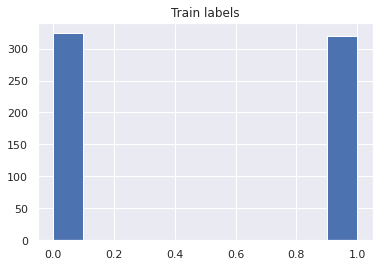

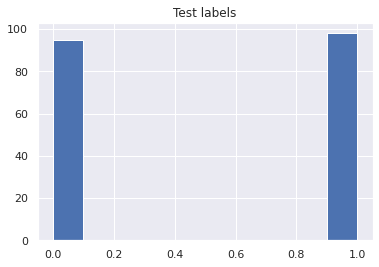

In [58]:
plt.hist(y_train)
plt.title("Train labels")
plt.show()

plt.hist(y_test)
plt.title("Test labels")
plt.show()

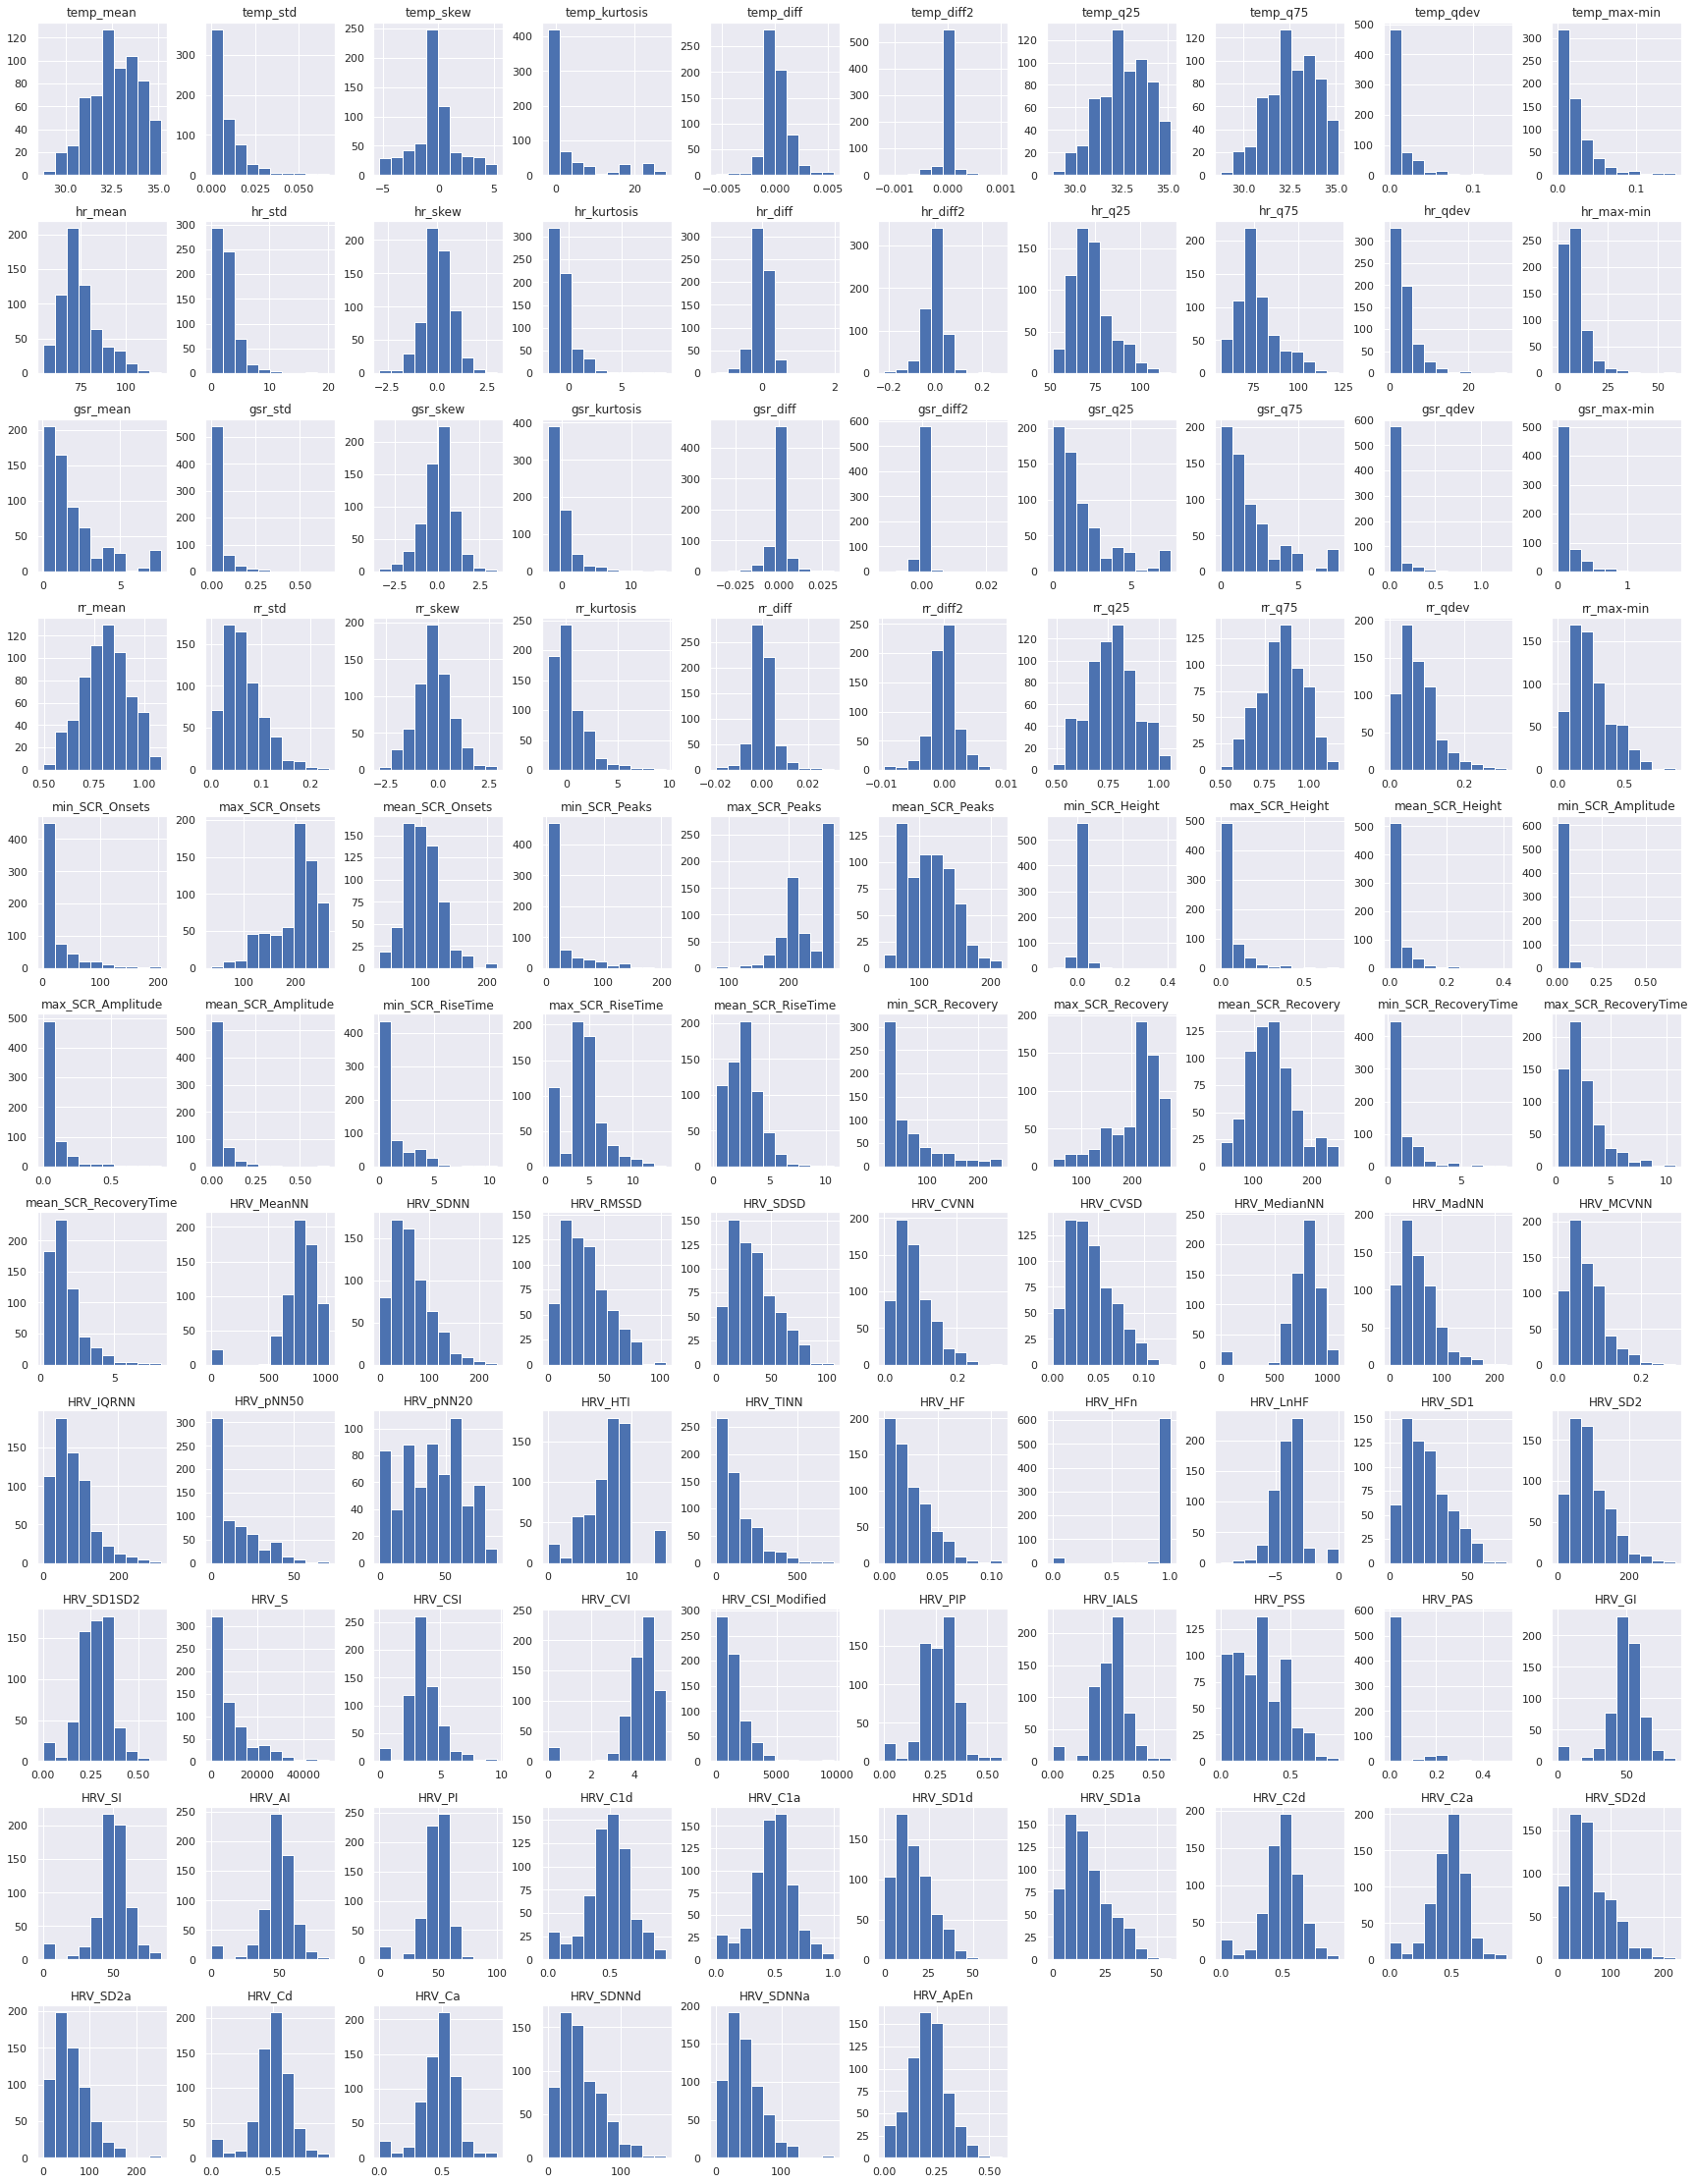

In [59]:
# plot distribution of training features
X_train.hist(figsize=(30, 40))
plt.show()

In [60]:
N_SPLITS = 5

Majority

In [61]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Majority classification report:")
print(classification_report(y_test, y_pred))

Majority classification report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        95
           1       0.00      0.00      0.00        98

    accuracy                           0.49       193
   macro avg       0.25      0.50      0.33       193
weighted avg       0.24      0.49      0.32       193



In [62]:
selector = SelectKBest(mutual_info_classif, k=50)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

Random forest

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

dummy = RandomForestClassifier()
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print("Random forest classification report:")
print(classification_report(y_test, y_pred))

Random forest classification report:
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        95
           1       0.67      0.64      0.66        98

    accuracy                           0.66       193
   macro avg       0.66      0.66      0.66       193
weighted avg       0.66      0.66      0.66       193



In [64]:
dummy = RandomForestClassifier()
dummy.fit(X_train_reduced, y_train)
y_pred = dummy.predict(X_test_reduced)

print("Random forest classification report:")
print(classification_report(y_test, y_pred))

Random forest classification report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62        95
           1       0.63      0.62      0.63        98

    accuracy                           0.62       193
   macro avg       0.62      0.62      0.62       193
weighted avg       0.62      0.62      0.62       193



AdaBoost

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AdaBoost classification report:")
print(classification_report(y_test, y_pred))

AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.65        95
           1       0.66      0.58      0.62        98

    accuracy                           0.63       193
   macro avg       0.63      0.63      0.63       193
weighted avg       0.63      0.63      0.63       193



In [66]:
clf = AdaBoostClassifier()
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

print("AdaBoost classification report:")
print(classification_report(y_test, y_pred))

AdaBoost classification report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        95
           1       0.57      0.46      0.51        98

    accuracy                           0.55       193
   macro avg       0.55      0.55      0.55       193
weighted avg       0.55      0.55      0.55       193



*k*-Nearest neighbors

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [68]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("k-Nearest neighbors classification report:")
print(classification_report(y_test, y_pred))

k-Nearest neighbors classification report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55        95
           1       0.58      0.61      0.59        98

    accuracy                           0.58       193
   macro avg       0.57      0.57      0.57       193
weighted avg       0.58      0.58      0.57       193



In [69]:
clf = KNeighborsClassifier()
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

print("k-Nearest neighbors classification report:")
print(classification_report(y_test, y_pred))

k-Nearest neighbors classification report:
              precision    recall  f1-score   support

           0       0.60      0.65      0.63        95
           1       0.63      0.58      0.61        98

    accuracy                           0.62       193
   macro avg       0.62      0.62      0.62       193
weighted avg       0.62      0.62      0.62       193



Naive Bayes

In [70]:
# https://scikit-learn.org/stable/modules/naive_bayes.html

estimator = GaussianNB()
clf = cross_validate(
    estimator=estimator,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    cv=N_SPLITS,
    n_jobs=-1,
)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print("Naive Bayes classification report")
print(classification_report(y_test, y_pred))

Naive Bayes classification report
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        95
           1       0.55      0.65      0.60        98

    accuracy                           0.55       193
   macro avg       0.56      0.55      0.55       193
weighted avg       0.56      0.55      0.55       193



In [71]:
# https://scikit-learn.org/stable/modules/naive_bayes.html

estimator = GaussianNB()
estimator.fit(X_train_reduced, y_train)
y_pred = estimator.predict(X_test_reduced)

print("Naive Bayes classification report")
print(classification_report(y_test, y_pred))

Naive Bayes classification report
              precision    recall  f1-score   support

           0       0.57      0.49      0.53        95
           1       0.57      0.64      0.60        98

    accuracy                           0.57       193
   macro avg       0.57      0.57      0.57       193
weighted avg       0.57      0.57      0.57       193



Decision Tree

In [72]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Decision tree classification report:")
print(classification_report(y_test, y_pred))

Decision tree classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        95
           1       0.62      0.54      0.58        98

    accuracy                           0.60       193
   macro avg       0.60      0.60      0.59       193
weighted avg       0.60      0.60      0.59       193



In [73]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

print("Decision tree classification report:")
print(classification_report(y_test, y_pred))

Decision tree classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        95
           1       0.62      0.54      0.58        98

    accuracy                           0.60       193
   macro avg       0.60      0.60      0.59       193
weighted avg       0.60      0.60      0.59       193



Logistic Regression

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Logistic regression classification report:")
print(classification_report(y_test, y_pred))

Logistic regression classification report:
              precision    recall  f1-score   support

           0       0.60      0.64      0.62        95
           1       0.63      0.58      0.60        98

    accuracy                           0.61       193
   macro avg       0.61      0.61      0.61       193
weighted avg       0.61      0.61      0.61       193



In [75]:
clf = LogisticRegression()
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

print("Logistic regression classification report:")
print(classification_report(y_test, y_pred))

Logistic regression classification report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57        95
           1       0.59      0.62      0.61        98

    accuracy                           0.59       193
   macro avg       0.59      0.59      0.59       193
weighted avg       0.59      0.59      0.59       193



Bagging

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = BaggingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Bagging classification report:")
print(classification_report(y_test, y_pred))

Bagging classification report:
              precision    recall  f1-score   support

           0       0.55      0.69      0.62        95
           1       0.61      0.46      0.52        98

    accuracy                           0.58       193
   macro avg       0.58      0.58      0.57       193
weighted avg       0.58      0.58      0.57       193



In [77]:
clf = BaggingClassifier()
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

print("Bagging classification report:")
print(classification_report(y_test, y_pred))

Bagging classification report:
              precision    recall  f1-score   support

           0       0.54      0.72      0.62        95
           1       0.60      0.42      0.49        98

    accuracy                           0.56       193
   macro avg       0.57      0.57      0.56       193
weighted avg       0.57      0.56      0.56       193



XGBoost

In [78]:
gk = GroupKFold(n_splits=5)  # TODO try 5-fold
splits = gk.get_n_splits(X_train, y_train, TRAIN_IDS)
print(type(gk))

<class 'sklearn.model_selection._split.GroupKFold'>


In [79]:
# ≈ 2 s

estimator = XGBClassifier(n_jobs=-1)
clf = cross_validate(
    estimator=estimator,
    X=X_train,
    y=y_train,
    scoring="accuracy",
    cv=N_SPLITS,
    n_jobs=-1,
)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print("XGBoost classification report")
print(classification_report(y_test, y_pred))

XGBoost classification report
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        95
           1       0.65      0.71      0.68        98

    accuracy                           0.66       193
   macro avg       0.66      0.66      0.66       193
weighted avg       0.66      0.66      0.66       193



In [80]:
# ≈ 2 s

estimator = XGBClassifier(n_jobs=-1)
estimator.fit(X_train_reduced, y_train)
y_pred = estimator.predict(X_test_reduced)

print("XGBoost classification report")
print(classification_report(y_test, y_pred))

XGBoost classification report
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        95
           1       0.61      0.64      0.62        98

    accuracy                           0.61       193
   macro avg       0.61      0.61      0.61       193
weighted avg       0.61      0.61      0.61       193



In [81]:
# ≈ 2 min

import time

s = time.time()

estimator = XGBClassifier(n_jobs=-1)
fs_clf = RFECV(
    estimator=estimator,
    step=1,
    cv=N_SPLITS,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=-1,
)

fs_clf.fit(X_train, y_train)
y_pred = fs_clf.predict(X_test)

selected_features = X_train.columns[fs_clf.ranking_ == 1]

print("XGBoost classification report")
print(classification_report(y_test, y_pred))

print("Selected features:", selected_features)

print(time.time() - s)

XGBoost classification report
              precision    recall  f1-score   support

           0       0.66      0.60      0.63        95
           1       0.64      0.70      0.67        98

    accuracy                           0.65       193
   macro avg       0.65      0.65      0.65       193
weighted avg       0.65      0.65      0.65       193

Selected features: Index(['temp_std', 'temp_skew', 'temp_diff2', 'hr_mean', 'hr_skew',
       'hr_kurtosis', 'hr_diff2', 'hr_q25', 'hr_qdev', 'hr_max-min',
       'gsr_mean', 'gsr_std', 'gsr_skew', 'gsr_kurtosis', 'gsr_diff',
       'gsr_diff2', 'gsr_qdev', 'gsr_max-min', 'rr_skew', 'rr_kurtosis',
       'rr_q25', 'rr_q75', 'rr_qdev', 'max_SCR_Peaks', 'min_SCR_Height',
       'mean_SCR_Height', 'min_SCR_Amplitude', 'max_SCR_Amplitude',
       'min_SCR_RiseTime', 'max_SCR_RiseTime', 'mean_SCR_RiseTime',
       'min_SCR_Recovery', 'max_SCR_Recovery', 'mean_SCR_Recovery',
       'mean_SCR_RecoveryTime', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN'

Multitask Learning

Multilayer Perceptron